In [1]:
# Initial imports
import pandas as pd
from pathlib import Path

In [2]:
#Read myopia.csv into a Pandas DataFrame.
file_path = Path("myopia.csv")
myopia_df = pd.read_csv(file_path)
myopia_df.head()

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY,MYOPIC
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1,0
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0,0


# Part 1: Prepare the Data

Remove the "MYOPIC" column from the dataset.
Note: The target column is needed for supervised machine learning, but it will make an unsupervised model biased. After all, the target column is effectively providing clusters already!

In [3]:
target = myopia_df["MYOPIC"].values
X = myopia_df.drop("MYOPIC", axis = 1)

Standardize your dataset so that columns that contain larger values do not influence the outcome more than columns with smaller values.

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Part 2: Apply Dimensionality Reduction

Perform dimensionality reduction with PCA. How did the number of the features change?

Hint: Rather than specify the number of principal components when you instantiate the PCA model, state the desired explained variance. For example, say that a dataset has 100 features. Using PCA(n_components=0.99) creates a model that will preserve approximately 99% of the explained variance, whether that means reducing the dataset to 80 principal components or 3. For this assignment, preserve 90% of the explained variance in dimensionality reduction.

In [5]:
#import PCA from sklearn
from sklearn.decomposition import PCA

# Initialize PCA model such that 90% of the explained variance is preserved
pca = PCA(n_components=0.9)

# Get the PCA model for the data.
myopia_pca = pca.fit_transform(X_scaled)

# Use the shape attribute to tell the # of principal components
myopia_pca.shape

(618, 10)

In [6]:
# Transform PCA data to a DataFrame
myopia_pca_df = pd.DataFrame(
    data=myopia_pca,
    columns=["pc 1", "pc 2", "pc 3", "pc 4", "pc 5", "pc 6", "pc 7", "pc 8", "pc 9", "pc 10"],
)
myopia_pca_df.head()

,pc 1,pc 2,pc 3,pc 4,pc 5,pc 6,pc 7,pc 8,pc 9,pc 10
0,0.535503,1.145004,-1.385019,0.116006,-3.226691,-1.928459,-1.958892,-1.922997,0.026753,0.178144
1,-0.624706,-1.575786,-0.794253,1.156287,0.292256,0.349060,-0.455206,0.285332,0.689683,-0.557031
2,-0.933479,-0.717076,0.820150,-1.547638,0.173941,0.272783,0.025821,-0.030817,-0.431499,0.013336
3,0.106354,1.192475,-0.024441,1.507469,-2.356836,-0.023139,0.236418,-1.717109,-1.230785,-0.703400
4,-0.388503,-2.839655,-0.229767,-0.622510,0.271458,-0.928956,0.537900,-1.301787,0.279007,0.631183


Further reduce the dataset dimensions with t-SNE and visually inspect the results. To do this, run t-SNE on the principal components, which is the output of the PCA transformation.

In [7]:
#import TSNE from sklearn
from sklearn.manifold import TSNE

# Run t-SNE
tsne = TSNE(learning_rate=250)
tsne_features = tsne.fit_transform(myopia_pca)

# Check that dimensions have been reduced to two
tsne_features.shape

/Users/mirandahermes/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


(618, 2)

Create a scatter plot of the t-SNE output. Are there distinct clusters?

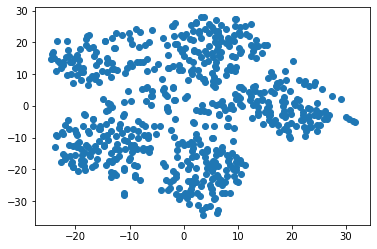

In [8]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Plot the results
plt.scatter(tsne_features[:,0], tsne_features[:,1])
plt.show()

Based on this scatter plot of the t-SNE output, there appear to be distinct clusters in this data. However, the clusters are not clearly defined. There appear to be at least two clusters, but possibly 3 or 4.

# Part 3: Perform a Cluster Analysis with K-means

Create an elbow plot to identify the best number of clusters. Make sure to do the following:
* Use a for loop to determine the inertia for each k between 1 through 10.
* If possible, determine where the elbow of the plot is, and at which value of k it appears.

In [9]:
# Import KMeans from sklearn
from sklearn.cluster import KMeans

# Create an empty list for inertia values and a list from 1 to 10 for k values
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(tsne_features)
    inertia.append(km.inertia_)

# Create an Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()

,k,inertia
0,1,255826.578125
1,2,143795.125000
2,3,86128.484375
3,4,61547.996094
4,5,39653.226562


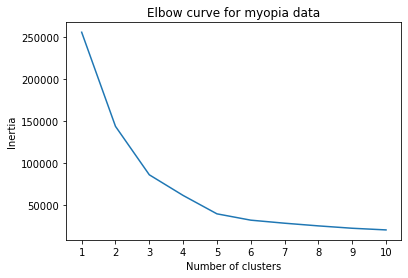

In [10]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for myopia data')
plt.show()

In [11]:
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [12]:
# Create a data frame with tsne_features
tsne_features_df = pd.DataFrame(tsne_features)
tsne_features_df = tsne_features_df.rename(columns={0: "Dimension 1", 1: "Dimension 2"})
tsne_features_df

,Dimension 1,Dimension 2
0,-2.963678,16.169968
1,6.612622,16.060673
2,2.257016,-19.693922
3,-18.447039,-2.482654
4,12.900546,6.004363
...,...,...
613,0.295124,2.563169
614,6.655101,15.474834
615,-11.087176,-27.402786
616,-0.918327,-25.922621


In [13]:
clusters = get_clusters(5, tsne_features_df)
clusters

,Dimension 1,Dimension 2,class
0,-2.963678,16.169968,3
1,6.612622,16.060673,3
2,2.257016,-19.693922,4
3,-18.447039,-2.482654,2
4,12.900546,6.004363,0
...,...,...,...
613,0.295124,2.563169,3
614,6.655101,15.474834,3
615,-11.087176,-27.402786,2
616,-0.918327,-25.922621,4


In [14]:
def show_clusters(df):
    plt.scatter(df['Dimension 1'], df['Dimension 2'], c=df['class'])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

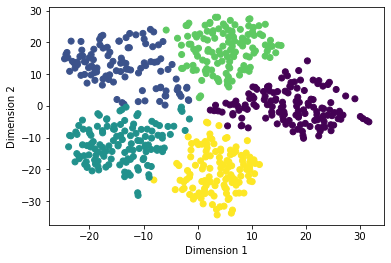

In [15]:
show_clusters(clusters)

# Part 4: Make a Recommendation

Based on this analysis, patients can be confidently clustered into 5 groups. The scatterplot above shows a 2-dimensional visual depiction of how patients can be clustered into 5 distinct groups. A PCA Analysis shows that there would be 10 primary components that would factor into such a grouping. Using 5 clusters of patients minimizes the iniertia while also minimizing the number of clusters required to group the patients into. This can be seen in the elbow curve above.